<a href="https://colab.research.google.com/github/Pukar33/CBEAS-Project/blob/main/Hiipocampus_Trial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Image, Label and FreeSurferColorLUT Directory

In [ ]:
image_dir = "/content/drive/MyDrive/MNI_train_data/Hires/Resampled/image_files"
label_dir = "/content/drive/MyDrive/MNI_train_data/Hires/Resampled/label_files"

##Libraries Import

In [ ]:
!pip install "monai==1.4.1rc1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.5 MB/s eta 0:00:00


In [ ]:
import glob
import pandas as pd
import os
import sys

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader, Dataset, MetaTensor
from monai.handlers import (
    MeanDice,
    MLFlowHandler,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandSpatialCrop,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import (
    first,
    set_determinism,
)

set_determinism(40)
import torch
import torch.nn as nn
import torch.optim as optim

print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.47.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

##Image & Labels Extraction and Visualization

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

In [ ]:
len(images), len(labels)

(25, 25)

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(label_image[slice_num, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(label_image[slice_num, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




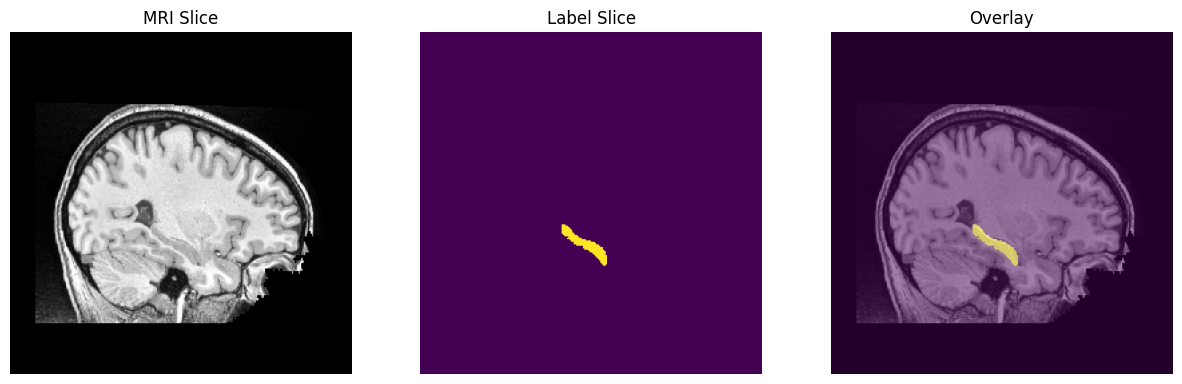

In [ ]:
visualize_image(images[0],labels[0], 100)

##Image Transforms and Custom Dataset

####Function to make labels contiguous

####Transforms

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    Resize((128, 128, 128)),
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    EnsureChannelFirst(),
    Resize((128, 128, 128), mode="nearest"),
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [ ]:

data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files = data_dicts[:20]
val_files   = data_dicts[20:]

In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)

In [ ]:
img_sample, seg_sample = train_ds[0]
print("Image shape:", img_sample.shape)
print("Label shape:", seg_sample.shape)

img_np = img_sample.squeeze().numpy()
seg_np = seg_sample.squeeze().numpy()


Image shape: torch.Size([1, 128, 128, 128])
Label shape: torch.Size([1, 128, 128, 128])


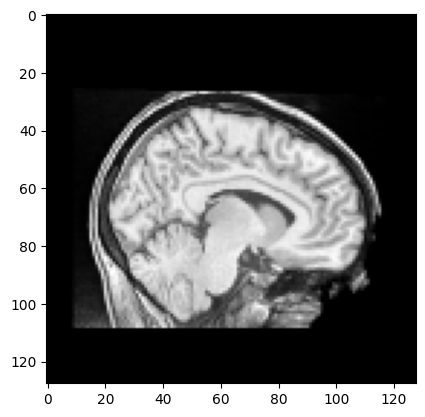

In [ ]:
plt.imshow(img_np[60, :, :], cmap="gray")
plt.show()

##Model

In [ ]:
num_classes = 2
from monai.networks.nets import SwinUNETR

model = SwinUNETR(
    img_size=(128, 128, 128),
    in_channels=1,
    out_channels=num_classes,
).cuda()


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Loss function, optimizer and dice

In [ ]:
pretrained_dict = torch.load('/content/drive/MyDrive/Checkpoints/150_epoch_best_model.pth', map_location='cpu')

model_dict = model.state_dict()

filtered_dict = {
    k: v
    for k, v in pretrained_dict.items()
    if k in model_dict and model_dict[k].shape == v.shape
}

model_dict.update(filtered_dict)
model.load_state_dict(model_dict)


<ipython-input-16-c18e42a53959>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('/content/drive/MyDrive/Checkpoints/150_epoch_best_model.pth', 

<All keys matched successfully>

In [ ]:
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

In [ ]:
from monai.inferers import sliding_window_inference
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

##Functions to load and save model and checkpoints

In [ ]:
def save_best_model(model, path):
    torch.save(model.state_dict(), path)

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, '/content/drive/MyDrive/Checkpoints_hippo/hippo_150_epoch_1e-2_Checkpoint_SwinUnetr.pth')


In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

In [ ]:
"""checkpoint = torch.load('/content/drive/MyDrive/Checkpoints/150_epoch_Checkpoint_SwinUnetr.pth')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
dice_mean = checkpoint['dice_mean']
epoch_list = checkpoint['epoch_list']
val_dice_list = checkpoint['val_dice_list']
train_loss_list = checkpoint['train_loss_list']"""

"checkpoint = torch.load('/content/drive/MyDrive/Checkpoints/150_epoch_Checkpoint_SwinUnetr.pth')\nmodel.load_state_dict(checkpoint['model_state_dict'])\n#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])\nepoch = checkpoint['epoch']\nloss = checkpoint['loss']\ndice_mean = checkpoint['dice_mean']\nepoch_list = checkpoint['epoch_list']\nval_dice_list = checkpoint['val_dice_list']\ntrain_loss_list = checkpoint['train_loss_list']"

In [ ]:
max_epochs = 90
val_interval = 3

In [ ]:
import datetime
print(datetime.datetime.now())

2025-01-19 17:50:26.202814


##Train and Validation Function

In [ ]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

In [ ]:
for epoch in range(epoch+1, max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")
    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch)

    # Validation
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            val_inputs = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (128, 128, 128)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)


        print(f"  Validation Dice: {dice_mean:.4f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, '/content/drive/MyDrive/Checkpoints_hippo/hippo_150_epoch_1e-2_best_model.pth')
            print("   Saved new best model")


print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch [61/90] 2025-01-19 18:16:04.561342
  Train loss: 0.0242
Epoch [62/90] 2025-01-19 18:16:25.491335
  Train loss: 0.0237
Epoch [63/90] 2025-01-19 18:16:46.581572
  Train loss: 0.0241
  Validation Dice: 0.9451
Epoch [64/90] 2025-01-19 18:17:13.112551
  Train loss: 0.0270
Epoch [65/90] 2025-01-19 18:17:33.913060
  Train loss: 0.0246
Epoch [66/90] 2025-01-19 18:17:54.781411
  Train loss: 0.0235
  Validation Dice: 0.9487
Epoch [67/90] 2025-01-19 18:18:21.291896
  Train loss: 0.0218
Epoch [68/90] 2025-01-19 18:18:42.238429
  Train loss: 0.0234
Epoch [69/90] 2025-01-19 18:19:03.608407
  Train loss: 0.0225
  Validation Dice: 0.9453
Epoch [70/90] 2025-01-19 18:19:30.076579
  Train loss: 0.0237
Epoch [71/90] 2025-01-19 18:19:50.872397
  Train loss: 0.0226
Epoch [72/90] 2025-01-19 18:20:12.341497
  Train loss: 0.0209
  Validation Dice: 0.9472
Epoch [73/90] 2025-01-19 18:20:38.815645
  Train loss: 0.0198
Epoch [74/90] 2025-01-19 18:20:59.540035
  Train loss: 0.0189
Epoch [75/90] 2025-01-19 18:

##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(90, 30, 30)

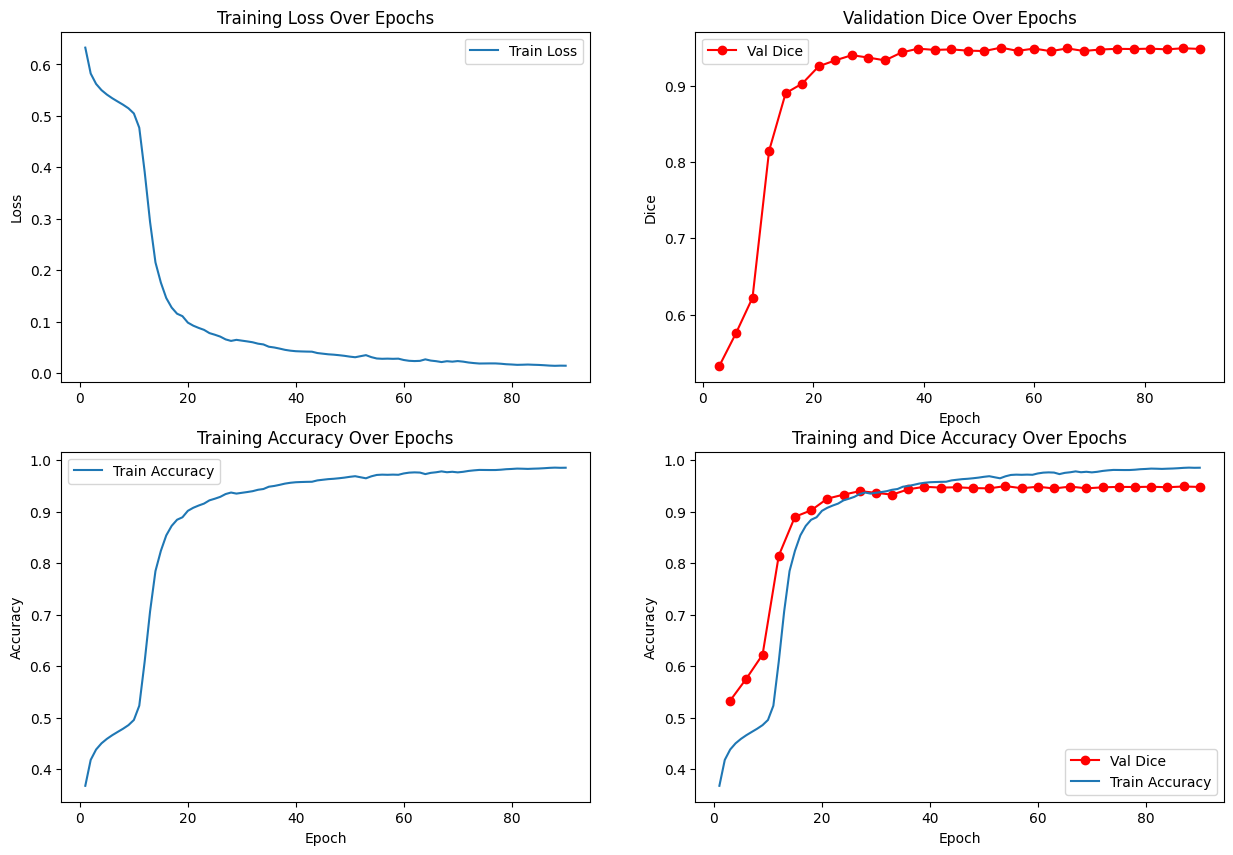

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()

axs[1, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[1, 1].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_title("Training and Dice Accuracy Over Epochs")
axs[1, 1].legend()

plt.show()

##Model Evaluation

In [ ]:
#model.load_state_dict(torch.load("/content/drive/MyDrive/best_metric_model_jan_01.pth"))
model.eval()

val_img, val_seg = val_ds[0]
val_img_ = val_img.unsqueeze(0).cuda()
with torch.no_grad():
    pred_logits = model(val_img_)
    pred_label  = torch.argmax(pred_logits, dim=1, keepdim=True)  # shape [1,1,D,H,W]

pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (128, 128, 128)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[0 1] 2


###Visualization of Predicted and Ground Truth Labels

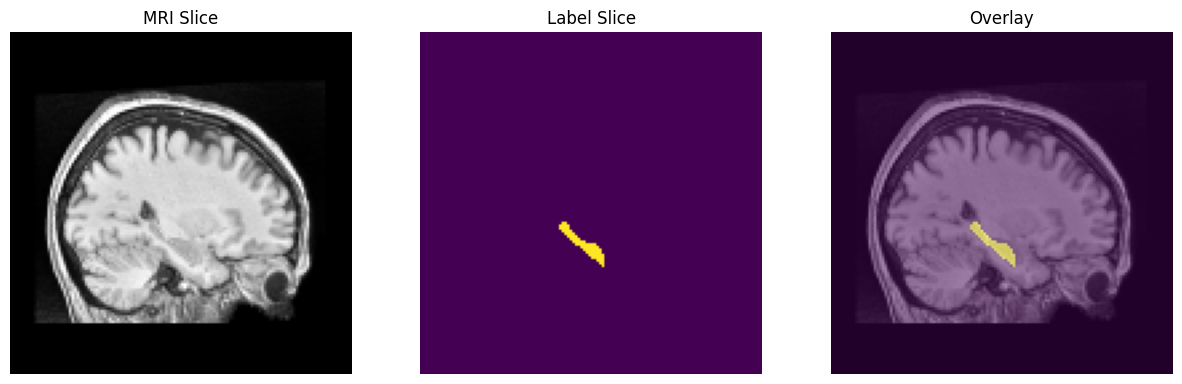

In [ ]:
#Prediction
visualize_image(val_img_np, pred_label_np, 77, array = True)

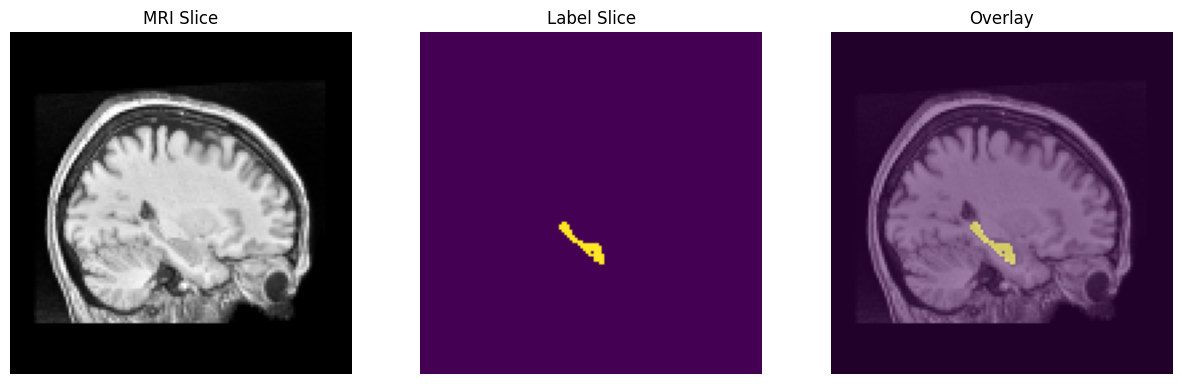

In [ ]:
#Ground Truth
visualize_image(val_img_np, val_seg_np, 77, array = True)